In [ ]:
import itertools
import pytz

import numpy as np
from tables import *
from datetime import datetime, timedelta

from tqdm import tqdm
import pandas as pd

from skyfield import api
from skyfield.sgp4lib import EarthSatellite
from skyfield.framelib import itrs

In [2]:
import sathelpers

Open up our reduced/cleaned TLE data. This is clipped to the AIS data ranges plus or minus a couple of weeks.

In [3]:
h5path = "/data/Indexed_TLE/reduced.h5"

In [4]:
with open("all_norad_ids.txt", "w") as f:
    for i in get_all_ids(h5path):
        f.write("%d\n" % i)

In [5]:
# This takes a couple seconds....
all_ids = get_all_ids(h5path)
len(all_ids)

19404

Lets really quick check that the windows we compute and the trajectories meet end-to-end for a semi-random data point

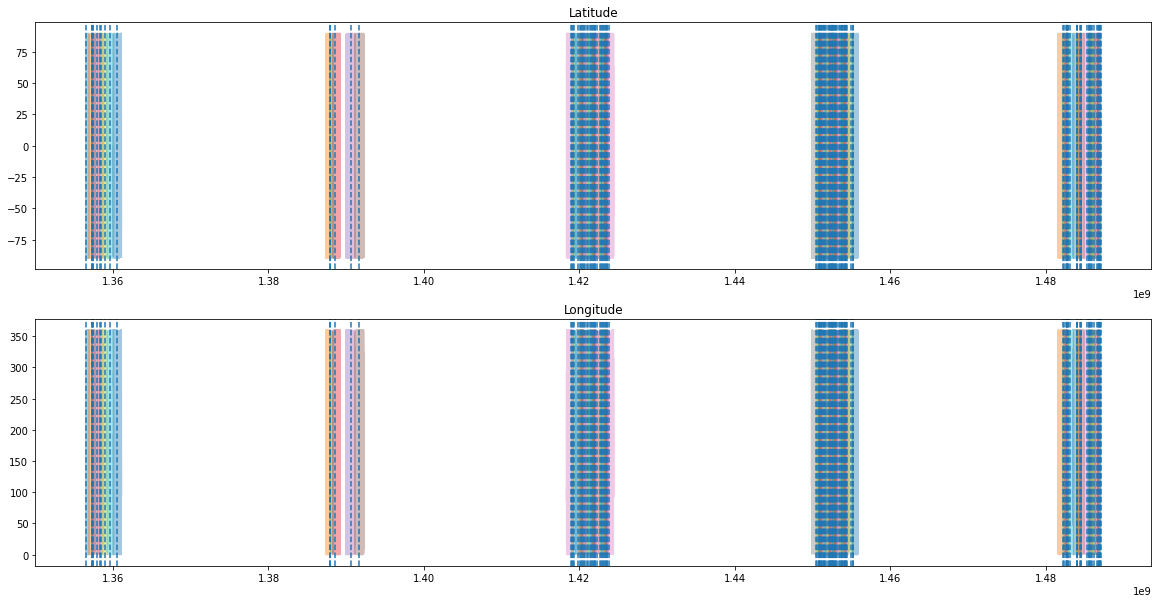

In [7]:
import matplotlib.pyplot as plt

def plot_lat_long_time(lat, long, t):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(20,  10)

    tlem = TLEManager(h5path, norad_id)
    windows = tlem.get_compute_windows()

    for i, (start, end, tle1, tle2) in enumerate(windows):
        times, lats, longs, alts = tlem.compute_lat_long_dist(start, end, tle1, tle2)

        ax1.set_title("Latitude")
        ax1.plot(times, lats, alpha=0.4)

        ax2.set_title("Longitude")
        ax2.plot(times, longs, alpha=0.4)


    # Add vertical lines where there are TLE epochs
    xmin, xmax = ax1.get_xlim()
    for t in tlem.get_tle_times():
        if(t > xmin and t < xmax):
            ax1.axvline(t, ls="--")
            ax2.axvline(t, ls="--")
    

def test_demo_plots(idee, start, stop):
    norad_id = list(all_ids)[-3001]
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(20,  10)

    tlem = TLEManager(h5path, norad_id)
    windows = tlem.get_compute_windows()

    for i, (start, end, tle1, tle2) in enumerate(windows):
        times, lats, longs, alts = tlem.compute_lat_long_dist(start, end, tle1, tle2)

        ax1.set_title("Latitude")
        ax1.plot(times, lats, alpha=0.4)

        ax2.set_title("Longitude")
        ax2.plot(times, longs, alpha=0.4)


    # Add vertical lines where there are TLE epochs
    xmin, xmax = ax1.get_xlim()
    for t in tlem.get_tle_times():
        if(t > xmin and t < xmax):
            ax1.axvline(t, ls="--")
            ax2.axvline(t, ls="--")

test_demo_plots()

This looks ok at a cursory glance. You can see the 5 years of AIS data windows. Dotted lines show where the TLE elements are. The differently shaded regions correspond to different TLE's used in the computation. This set was selected to highlight the abiulity to adapt to different data densities.

In [6]:
# This is a little shim to make the parallel calls further down a bit simpler to read
def do_the_work(sat_id: int):
    return TLEManager(sat_id).compute_tlla_sequence()

In [7]:
# Trying Dask: could not get to work :/
#from dask.distributed import Client, as_completed
#client = Client(memory_limit='8GB')  # start local workers as processes

# Using concurrent.futures:
from concurrent.futures import ProcessPoolExecutor, as_completed
client = ProcessPoolExecutor(max_workers=22)

client

In [8]:
# Import out satellite data storage class


In [9]:
# Open the output file for the precomputed tracks
precompute = open_file("/data/Indexed_TLE/last_precomp.h5", "a")

# Create a hdf5 node to store the tracks in, or use an existing one
if not hasattr(precompute.root, "sat"):
    print("Created new group")
    sat_group = precompute.create_group("/", "sat", "Precomputed satellite position cache")
else:
    print("Found existing group")
    sat_group = precompute.get_node("/sat")

# Init the data store using the node specified
sds = SatelliteDataStore(sat_group)

# Determine which trajectories have already been computed
completed = sds.get_norad_ids()
print("Already completed: %i" % len(completed))
todo_ids = set(all_ids).difference(completed)

# Submit all work to the parallel executor, keying the future to the norad_id
fut_to_id = {client.submit(do_the_work, sat_id): sat_id for sat_id in todo_ids}

# As work gets completed, add the trace to the data store, and update a progress bar
with tqdm(total=len(fut_to_id)) as pbar:
    for fut in as_completed(fut_to_id.keys()):
        sds.put_precomputed_tracks(fut_to_id[fut], fut.result())
        pbar.update(1)

Found existing group
Already completed: 4233


  3%|▎         | 385/15171 [2:23:24<91:47:56, 22.35s/it] 


KeyboardInterrupt: 

In [10]:
# close the datastore and cleanup the process pool
precompute.close()
client.shutdown(wait=False)

In [ ]:
# Quick noodle to get the lat-long of a satellite at epoch
from skyfield.framelib import itrs
from skyfield.sgp4lib import EarthSatellite


def compute_lat_long_dist(self, tle1, tle2):
        """
        Get the Lat/Long at the tle epoch  
        """
        # Do the actual satellite propogation math
        sat = EarthSatellite(tle1.decode(), tle2.decode())
        lat, long = sat.at(sat.epoch).frame_latlon(itrs)
        
        # return the times, lats, longs, and distances in the units specified
        return lat.degrees[0], long.degrees[0]